In [19]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.10.0


In [20]:
# Si ves una lista con al menos un dispositivo GPU, TensorFlow la está detectando.
# Si la lista está vacía ([]), TensorFlow no está usando la GPU.
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Importación de librerias.

In [21]:
(imagenes_entrenamiento, etiquetas_entrenamiento ), (imagenes_verificacion, etiquetas_verificacion) = keras.datasets.cifar10.load_data()

Carga de conjunto de datos de imagenes para entrenamiento. 50.000 fotos en color de 32x32 pixels de aviones, trenes, autos, etc con etiquetas. 10000 fotos para testear

In [22]:
print(etiquetas_entrenamiento.shape, imagenes_entrenamiento.shape)

(50000, 1) (50000, 32, 32, 3)


In [23]:
imagenes_entrenamiento, imagenes_verificacion = imagenes_entrenamiento / 255.0, imagenes_verificacion  / 255.0

AGREGADO: Estandarizacion entre 0s y 1s

In [24]:
nombres_clases = ['airplane','automobile','bird','cat','deer',
                  'dog','frog','horse','ship','truck']

Funcion para mostrar imagenes en miniatura.

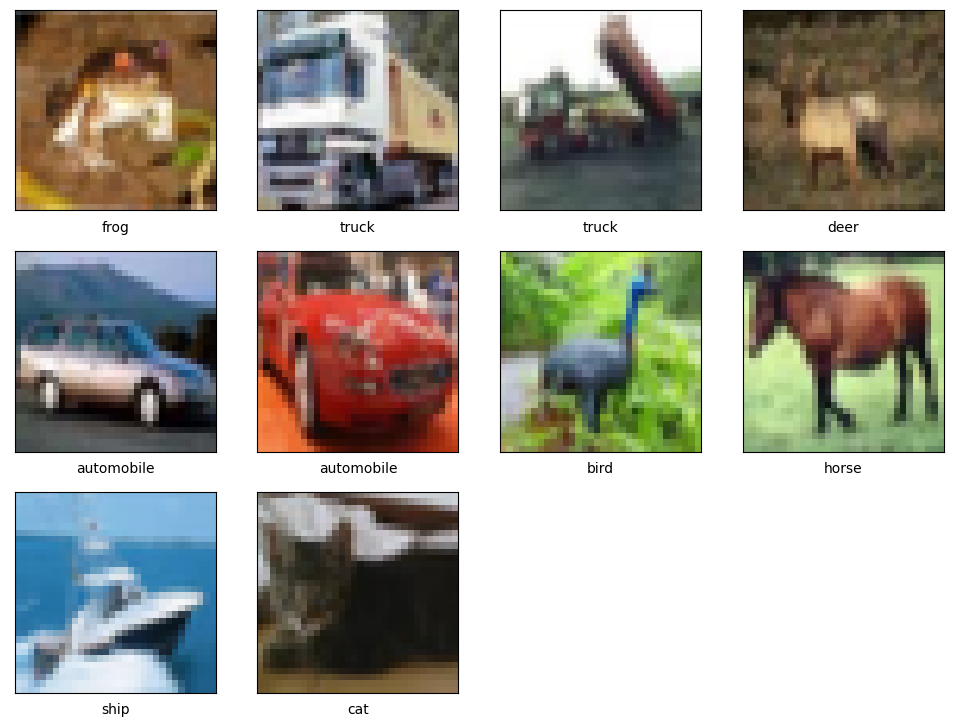

In [26]:
import matplotlib.pyplot as plt
def mostrar():
  plt.figure(figsize=(12,12))
  for i in range(10):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagenes_entrenamiento[i], cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[etiquetas_entrenamiento[i][0]])
  plt.show()
mostrar()

Una capa de entrada para imagenes de 32x32 pixels con 3 dimensiones de colores.
Dos capas convolucionales para extraer caracteristicas, con 32 filtros de 3x3. Quitando relleno que no se ajusta.
Dos capas de agrupamiento con filtros de 2x2 para achicar la anterior.

Una capa complemtamente conectada (densa) con 64 neuronas.
Una capa de salida con 10 neuronas para clasificar.

In [27]:
# Definimos la arquitectura de la red convolucional que usamos en el grupo.
# Cada capa cumple una función específica para que el modelo aprenda a reconocer imágenes.

capa = keras.layers
modelo = keras.models.Sequential()

# Primera capa convolucional: extrae características simples (bordes, colores, texturas) de las imágenes.
modelo.add(capa.Conv2D(64, (3,3), padding="same", activation='relu', input_shape=(32,32,3)))
# Normalizamos la salida para que el entrenamiento sea más estable.
modelo.add(capa.BatchNormalization())

# Segunda capa convolucional: aprende combinaciones más complejas de las características anteriores.
modelo.add(capa.Conv2D(64, (3,3), padding="same", activation='relu'))
modelo.add(capa.BatchNormalization())

# MaxPooling: reduce el tamaño de la imagen y ayuda a que el modelo se enfoque en lo más importante.
modelo.add(capa.MaxPool2D(2,2))

# Dropout: apaga aleatoriamente el 40% de las neuronas para evitar que el modelo memorice y así generalice mejor.
modelo.add(capa.Dropout(0.4))

# Tercera capa convolucional: ahora el modelo puede aprender patrones aún más complejos.
modelo.add(capa.Conv2D(128, (3,3), padding="same", activation='relu'))
modelo.add(capa.BatchNormalization())

# Cuarta capa convolucional: sigue profundizando en los patrones de la imagen.
modelo.add(capa.Conv2D(128, (3,3), padding="same", activation='relu'))
modelo.add(capa.BatchNormalization())

# Otro MaxPooling para seguir reduciendo la dimensionalidad y enfocarnos en lo esencial.
modelo.add(capa.MaxPool2D(2,2))

# Otro Dropout para seguir ayudando a la generalización.
modelo.add(capa.Dropout(0.4)) 

# Flatten: convertimos la imagen 2D en un vector 1D para poder conectarla con las capas densas.
modelo.add(capa.Flatten())

# Capa densa: aquí el modelo combina toda la información extraída para tomar decisiones.
# Usamos regularización L2 para evitar que los pesos crezcan demasiado.
modelo.add(capa.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))

# Dropout más alto en la densa porque aquí es donde más suele sobreajustar.
modelo.add(capa.Dropout(0.6))

# Capa de salida: 10 neuronas (una por clase), con softmax para que la suma de probabilidades sea 1.
modelo.add(capa.Dense(10, activation='softmax'))

# Mostramos el resumen del modelo para ver la cantidad de parámetros y cómo se conectan las capas.
modelo.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                      

Configuracion del modelo

In [28]:
from tensorflow.keras.optimizers import Adam

# Definimos el optimizador con learning rate bajo (acordado en grupo)
optimizer = Adam(learning_rate=0.0005)

# Compilamos el modelo con el nuevo optimizador
modelo.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ¿Por qué es importante el learning rate?
# - Es la tasa de aprendizaje: controla cuánto se ajustan los pesos del modelo en cada paso.
# - Un valor bajo (como 0.0005) hace que el modelo aprenda más lento pero de forma más precisa y estable.
# - Esto ayuda a evitar saltos bruscos y mejora la generalización.
# - Si el learning rate es muy alto, el modelo puede no converger o aprender de forma inestable.
# - Si es muy bajo, el entrenamiento puede ser muy lento o atascarse en mínimos locales.
# Por eso, en el grupo fuimos probando y nos quedamos con este valor porque nos dio mejores resultados en validación.

Entrenamiento (creación del modelo)

Loss se busca el número mas bajo. Accuracy el más alto

In [ ]:
# En el modelo original no se usaba data augmentation ni callbacks avanzados. Se agregangaron para mejorar la generalización y el control del entrenamiento.

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

# Data augmentation: solo transformaciones moderadas y útiles para CIFAR-10
# (flip horizontal, rotación leve, zoom, contraste y traslación)
data_augmentation_layers = Sequential([
    RandomFlip("horizontal"),           # Flip horizontal: útil para simetría de objetos
    RandomRotation(0.1),                # Rotación leve: simula variaciones reales
    RandomZoom(0.1),                    # Zoom leve: simula distintas distancias
    RandomContrast(0.1),                # Contraste leve: robustez ante iluminación
    RandomTranslation(0.1, 0.1)         # Traslación leve: simula desplazamientos
])

batch_size = 256  # En el original era 64, aquí se usa 256 para aprovechar la GPU y acelerar el entrenamiento

autotune = tf.data.AUTOTUNE

# Dataset de entrenamiento con shuffle, batch y data augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((imagenes_entrenamiento, etiquetas_entrenamiento))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation_layers(x, training=True), y), num_parallel_calls=autotune)
train_dataset = train_dataset.prefetch(buffer_size=autotune)

# Dataset de validación (sin data augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((imagenes_verificacion, etiquetas_verificacion))
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=autotune)

# Callbacks para entrenamiento robusto y controlado
# EarlyStopping: detiene si no mejora la val_loss (evita sobreentrenamiento)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)
# ModelCheckpoint: guarda el mejor modelo según val_accuracy
checkpoint = ModelCheckpoint(
    filepath='mejor_modelo.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
# ReduceLROnPlateau: baja el learning rate si la val_loss se estanca
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Entrenamiento: se usan los datasets y callbacks mejorados
# (En el original solo se entrenaba directo sobre los arrays, sin callbacks ni data augmentation)
history = modelo.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/200
Epoch 1/200
196/196 [==============================] - 25s 114ms/step - loss: 2.4250 - accuracy: 0.2058 - val_loss: 5.5648 - val_accuracy: 0.1025 - lr: 5.0000e-04
Epoch 2/200
Epoch 2/200
196/196 [==============================] - 25s 118ms/step - loss: 2.1492 - accuracy: 0.2708 - val_loss: 2.3226 - val_accuracy: 0.2499 - lr: 5.0000e-04
Epoch 3/200
Epoch 3/200
196/196 [==============================] - 24s 113ms/step - loss: 2.0178 - accuracy: 0.3123 - val_loss: 1.6233 - val_accuracy: 0.4585 - lr: 5.0000e-04
Epoch 4/200
Epoch 4/200
196/196 [==============================] - 23s 110ms/step - loss: 1.9085 - accuracy: 0.3542 - val_loss: 1.8040 - val_accuracy: 0.4187 - lr: 5.0000e-04
Epoch 5/200
Epoch 5/200
196/196 [==============================] - 24s 114ms/step - loss: 1.7990 - accuracy: 0.3815 - val_loss: 2.0266 - val_accuracy: 0.4147 - lr: 5.0000e-04
Epoch 6/200
Epoch 6/200
196/196 [==============================] - 24s 115ms/step - loss: 1.7237 - accuracy: 0.4139 - val_los

In [ ]:
modelo.evaluate(imagenes_verificacion, etiquetas_verificacion, batch_size=256)

40/40 [==============================] - 0s 6ms/step - loss: 0.7088 - accuracy: 0.8085


40/40 [==============================] - 0s 6ms/step - loss: 0.7088 - accuracy: 0.8085


[0.7088295817375183, 0.8084999918937683]

In [ ]:
#predict()

**CONTINUAR DESDE ACA**

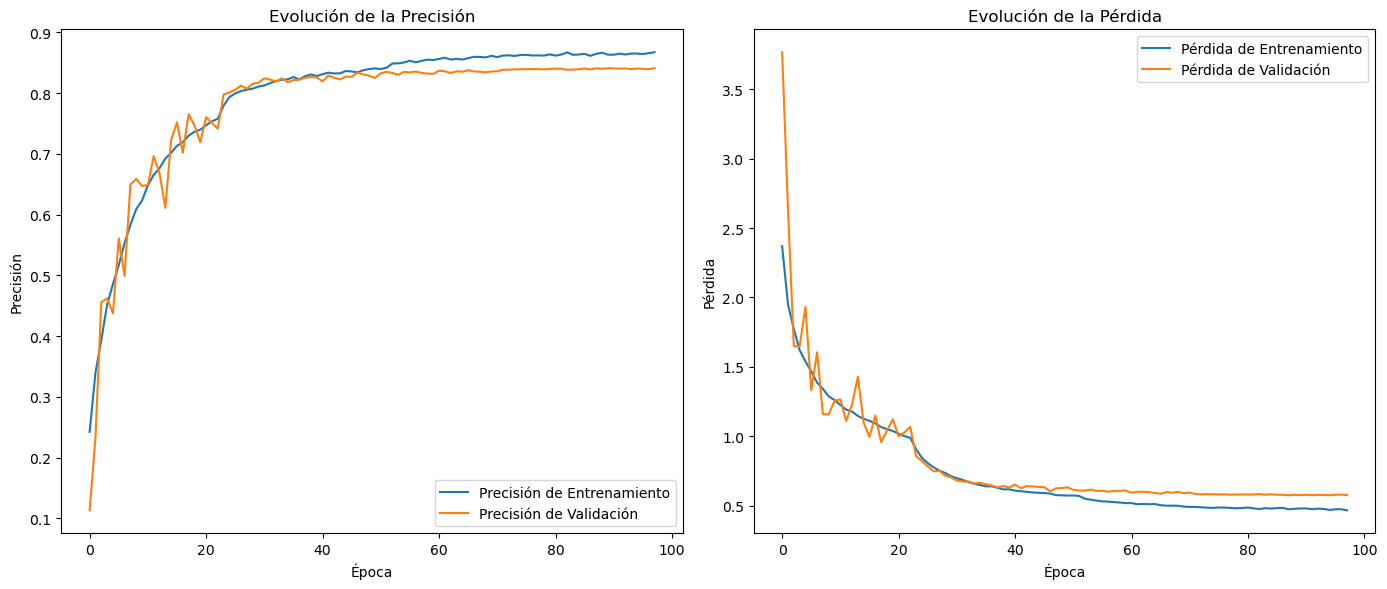

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir el historial a un DataFrame para facilitar el ploteo
history_df = pd.DataFrame(history.history)

# Graficar la precisión
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history_df['val_accuracy'], label='Precisión de Validación')
plt.title('Evolución de la Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Pérdida de Entrenamiento')
plt.plot(history_df['val_loss'], label='Pérdida de Validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Esta celda evalúa el mejor modelo guardado y permite validar visualmente su desempeño sobre el set de validación.
# Se muestran ejemplos aleatorios con la predicción y la etiqueta real, para detectar aciertos y errores de clasificación.
# Es útil para comunicar resultados y analizar el comportamiento del modelo en casos concretos.

import numpy as np

# Cargar el mejor modelo guardado por ModelCheckpoint
best_model = keras.models.load_model('mejor_modelo.keras')

# Evaluar el mejor modelo para confirmar su rendimiento global
loss, acc = best_model.evaluate(imagenes_verificacion, etiquetas_verificacion, verbose=0)
print(f'\nPrecisión del mejor modelo cargado: {acc*100:.2f}%')


# --- Hacer predicciones y visualizarlas ---
predictions = best_model.predict(imagenes_verificacion)

# Función para mostrar una imagen con su predicción y la etiqueta real
def plot_image_prediction(i, predictions_array, true_labels, img_array):
    true_label, img = true_labels[i][0], img_array[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    # Azul si acierta, rojo si se equivoca
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(f"Predicción: {nombres_clases[predicted_label]} ({100*np.max(predictions_array):2.0f}%)\nReal: {nombres_clases[true_label]}", color=color)

# Mostrar 15 imágenes aleatorias con sus predicciones
num_rows = 5
num_cols = 3
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    random_index = np.random.randint(0, len(imagenes_verificacion))
    plot_image_prediction(random_index, predictions[random_index], etiquetas_verificacion, imagenes_verificacion)
plt.tight_layout()
plt.show()

NameError: name 'keras' is not defined

In [ ]:
# Esta función permite cargar una imagen externa, preprocesarla y predecir su clase usando el modelo entrenado.
# Es útil para validar visualmente el desempeño del modelo con imágenes nuevas o de producción.
# Muestra la imagen, la predicción y el nivel de confianza, facilitando la interpretación de resultados.

import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predecir_imagen_externa(ruta_imagen, modelo):
    try:
        # 1. Cargar la imagen y redimensionarla a 32x32 píxeles
        img = image.load_img(ruta_imagen, target_size=(32, 32))
        
        # 2. Convertir la imagen a un array de numpy y normalizarla
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        
        # 3. Añadir una dimensión extra para que represente un "lote" de 1 imagen
        img_batch = np.expand_dims(img_array, axis=0)
        
        # 4. Realizar la predicción
        prediccion = modelo.predict(img_batch)
        
        # 5. Obtener la clase con la probabilidad más alta
        clase_predicha = np.argmax(prediccion[0])
        confianza = np.max(prediccion[0]) * 100
        
        # 6. Mostrar la imagen y el resultado
        plt.imshow(img)
        plt.title(f"Predicción: {nombres_clases[clase_predicha]} ({confianza:.2f}%)")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo en la ruta '{ruta_imagen}'.")
    except Exception as e:
        print(f"Ocurrió un error al procesar la imagen: {e}")

In [1]:
import os

# 1. Define la ruta a tu carpeta con las imágenes YA PROCESADAS
CARPETA_PROCESADAS = r'E:\Procesamiento de Aprendizaje Automatico\Tp\pichichas_procesadas'

try:
    # 2. Obtener la lista de todos los archivos en la carpeta procesada
    lista_de_archivos = os.listdir(CARPETA_PROCESADAS)
    
    extensiones_validas = ('.png', '.jpg', '.jpeg', '.bmp')
    imagenes_a_predecir = [f for f in lista_de_archivos if f.lower().endswith(extensiones_validas)]

    if not imagenes_a_predecir:
        print(f"No se encontraron imágenes en la carpeta: {CARPETA_PROCESADAS}")
        print("Asegúrate de haber ejecutado primero el script 'preprocesar_imagenes.py'.")
    else:
        print(f"Iniciando predicciones para las {len(imagenes_a_predecir)} imágenes procesadas...")
        
        # 3. Recorrer cada imagen y llamar a la función de predicción
        for nombre_archivo in imagenes_a_predecir:
            ruta_completa = os.path.join(CARPETA_PROCESADAS, nombre_archivo)
            
            print(f"\n--- Prediciendo: {nombre_archivo} ---")
            
            # Llamar a la función que definiste en la celda anterior
            predecir_imagen_externa(ruta_completa, best_model)

except FileNotFoundError:
    print(f"Error: No se encontró la carpeta en la ruta '{CARPETA_PROCESADAS}'.")
    print("Por favor, asegúrate de que la ruta es correcta y que has ejecutado 'preprocesar_imagenes.py'.")
except NameError:
    print("Error: La variable 'best_model' o la función 'predecir_imagen_externa' no están definidas.")
    print("Por favor, ejecuta primero las celdas anteriores que las definen.")

Iniciando predicciones para las 5 imágenes procesadas...

--- Prediciendo: Imagen de WhatsApp 2025-06-19 a las 16.22.56_12933fd4.jpg ---
Error: La variable 'best_model' o la función 'predecir_imagen_externa' no están definidas.
Por favor, ejecuta primero las celdas anteriores que las definen.


# Ajuste del Learning Rate
Se implementará una estrategia de warm-up para el learning rate, donde este comenzará con un valor bajo y aumentará gradualmente durante las primeras épocas. Esto puede ayudar a estabilizar el entrenamiento inicial y mejorar la convergencia del modelo.

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def warmup_scheduler(epoch):
    if epoch < 5:
        return 0.0001 + (epoch * (0.0005 - 0.0001) / 5)
    return 0.0005

# Añadir el callback de warm-up al entrenamiento
warmup_callback = LearningRateScheduler(warmup_scheduler)

# Actualizar el entrenamiento para incluir el warm-up
history = modelo.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint, reduce_lr, warmup_callback]
)